# Strategy Details

### COde Author: Karl Ngan

Reference: Terrence Hendershott, Dmitry Livdan, Dominik Rösch, "Asset pricing: A tale of night and day",
Journal of Financial Economics,Volume 138, Issue 3,2020


Link to reference: https://www.sciencedirect.com/science/article/abs/pii/S0304405X20301732

The main idea: The idea is similar to bet against beta, but taking the Night returns into account

### The part that is not same as the paper
- The paper obtained the returns from Center for Research in Security Prices (CRSP). I am using yfinance instead
- The paper has a larger universe of 39 countries. Here I am using US equity stock market only
- Instead of replicating the paper from 1992-2016, I am doing it from 2014 to 2023


In [1]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm

start_date = '2014-01-01'
end_date = '2023-12-31'

In [2]:
# Get the list of S&P 500 companies from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
html = response.content

df = pd.read_html(html, header=0)[0]

tickers = df['Symbol'].tolist()
tickers.append('^GSPC')

In [3]:
def load_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start= start_date, end= end_date)

        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
    df['date'] = df.index

    if len(df) == 0:
        os.remove(file_name)
        return None

    return df

In [4]:
holder = []
ticker_with_data = []
for symbol in tickers:
    df = load_data(symbol)
    if df is not None:
        holder.append(df)
        ticker_with_data.append(symbol)

tickers = ticker_with_data[:]

print (f'Loaded data for {len(tickers)} companies')

BRK.B: No timezone found, symbol may be delisted
BF.B: No price data found, symbol may be delisted (1d 2014-01-01 -> 2023-12-31)
GEV: Data doesn't exist for startDate = 1388552400, endDate = 1703998800
SOLV: Data doesn't exist for startDate = 1388552400, endDate = 1703998800


Loaded data for 500 companies


In [5]:
#keep the Opening and Closing for calculating close-to-close returns and open-to-close returns
for stocks in holder:
    #open to close returns or Day returns
    stocks['Open_to_Close'] = (stocks['Close'] - stocks['Open']) / stocks['Open']
    #close to close returns
    #As yfinance did not provde close to close return as CRSP did, we calculate it by ourselves
    #Note that the close-to-close returns around holidays and weekends can be longer than 24 h.
    stocks['Close_to_Close'] = stocks['Close'].pct_change()     
    #Night returns
    stocks['Night_returns'] = (1+stocks['Close_to_Close']) / (1+stocks['Open_to_Close']) - 1


### Estimate beta by regressing the Night returns

In [6]:
def calculate_beta(stock_returns, market_returns):
    model = sm.OLS(stock_returns, sm.add_constant(market_returns))
    results = model.fit()
    beta = results.params.values[1]
    return beta


def add_beta(ticker_data, market_data):
    period = 252
    beta_holder = {}

    merged_df = pd.merge(
        ticker_data['Night_returns'],
        market_data['Night_returns'],
        how = 'left',
        left_index=True, right_index=True,
        suffixes=('_stock', '_market')
        )
    merged_df.dropna(inplace=True)


    for i, date in enumerate(merged_df.index):
        if i < period:
            continue
        
        #for the day i-period to i-1 , we calculate the beta based on the past 252 days
        stock_returns = merged_df.iloc[i-period:i]['Night_returns_stock']
        market_returns = merged_df.iloc[i-period:i]['Night_returns_market']

        beta = calculate_beta(stock_returns, market_returns)
        beta_holder[date] = beta

    beta_holder = pd.Series(beta_holder)
    beta_holder.name = 'Beta'
    beta_holder.index = pd.to_datetime(beta_holder.index, utc=True)
    beta_holder.index = beta_holder.index.tz_convert('US/Eastern')

    # Merge the beta with the original data
    ticker_data = pd.merge(ticker_data, beta_holder, how='left', left_index=True, right_index=True)

    return ticker_data


tickers_data = holder[0:-1]
market_data = holder[-1]

for ticker_index in range(len(tickers_data)):
    tickers_data[ticker_index] = add_beta(tickers_data[ticker_index] , market_data)
    print (tickers[ticker_index], "is about to be processed.")
    


MMM is about to be processed.
AOS is about to be processed.
ABT is about to be processed.
ABBV is about to be processed.
ACN is about to be processed.
ADBE is about to be processed.
AMD is about to be processed.
AES is about to be processed.
AFL is about to be processed.
A is about to be processed.
APD is about to be processed.
ABNB is about to be processed.
AKAM is about to be processed.
ALB is about to be processed.
ARE is about to be processed.
ALGN is about to be processed.
ALLE is about to be processed.
LNT is about to be processed.
ALL is about to be processed.
GOOGL is about to be processed.
GOOG is about to be processed.
MO is about to be processed.
AMZN is about to be processed.
AMCR is about to be processed.
AEE is about to be processed.
AAL is about to be processed.
AEP is about to be processed.
AXP is about to be processed.
AIG is about to be processed.
AMT is about to be processed.
AWK is about to be processed.
AMP is about to be processed.
AME is about to be processed.
AM

### Trading Strategy Overview 
Investing in extreme overnight returns beta stocks, similar idea as bet against beta, Panel B in the paper


Long low-beta stocks by shorting high-beta stocks when markets opens (Day returns)

Long high-beta stocks by shorting low-beta stocks when markets closes (Night returns)




In [12]:
period = 252
beta_df = pd.DataFrame()
for i in range(len(tickers_data)):
    beta_df = pd.concat([beta_df, tickers_data[i]['Beta']], axis=1)
beta_df.columns = tickers[:-1]
beta_df = beta_df[period+1:] 

Night_returns_df = pd.DataFrame()
for i in range(len(tickers_data)):
    Night_returns_df = pd.concat([Night_returns_df, tickers_data[i]['Night_returns']], axis=1)
Night_returns_df.columns = tickers[:-1]
Night_returns_df = Night_returns_df[period+1:]

Day_returns_df = pd.DataFrame()
for i in range(len(tickers_data)):
    Day_returns_df = pd.concat([Day_returns_df, tickers_data[i]['Open_to_Close']], axis=1)
Day_returns_df.columns = tickers[:-1]
Day_returns_df = Day_returns_df[period+1:]




In [80]:

def get_extreme_beta_stocks(beta_df , i):
    row = beta_df.iloc[i]
    #select stocks only if they have positive betas top 10 and bottom 10
    top_10 = row[row>0].sort_values(ascending=False).head(10)
    bottom_10 = row[row>0].sort_values(ascending=True).head(10)

    top_10_stocks = top_10.index.tolist()
    bottom_10_stocks = bottom_10.index.tolist()

    return top_10_stocks, bottom_10_stocks

def get_daily_return(beta_df):
    Day_returns_holder = []
    Night_returns_holder = []
    monthflag = 0
    for i in range(len(beta_df)):
        #Checking if this is the new month, if yes, extract the top 10 and bottom 10 stocks again
        if beta_df.index[i].month != monthflag:
            daily_top10, daily_bottom10 = get_extreme_beta_stocks(beta_df , i)
            monthflag = beta_df.index[i].month

            daily_average_beta = beta_df.loc[beta_df.index[i], daily_top10 + daily_bottom10].mean()

            high_beta_amount = (beta_df.loc[beta_df.index[i], daily_top10] - daily_average_beta)/daily_average_beta
            low_beta_amount = (beta_df.loc[beta_df.index[i], daily_bottom10] - daily_average_beta)/daily_average_beta


        #Day returns
        high_beta_day_returns = (Day_returns_df.loc[Day_returns_df.index[i], daily_top10]* -high_beta_amount).sum()
        low_beta_day_returns = (Day_returns_df.loc[Day_returns_df.index[i], daily_bottom10]* -low_beta_amount).sum()
        Day_returns_holder.append(high_beta_day_returns + low_beta_day_returns)    

        #Night returns
        high_beta_night_returns = (Night_returns_df.loc[Night_returns_df.index[i], daily_top10] * high_beta_amount).sum()
        low_beta_night_returns = (Night_returns_df.loc[Night_returns_df.index[i], daily_bottom10] * low_beta_amount).sum()
        Night_returns_holder.append(high_beta_night_returns + low_beta_night_returns)

    return Day_returns_holder, Night_returns_holder


Day_returns_holder, Night_returns_holder = get_daily_return(beta_df)

        


### Results

In [81]:
Returns_df = pd.DataFrame(Day_returns_holder)
Returns_df.index = beta_df.index
Returns_df.columns = ['Day_returns']
Returns_df['Night_returns'] = Night_returns_holder
Returns_df['Total_returns'] = Returns_df['Day_returns'] + Returns_df['Night_returns']

#The returns are not based on the initial investment amount
Returns_df['Cumulative_returns'] = Returns_df['Total_returns'].cumsum() 

#Sharpe
Day_Sharpe = (Returns_df['Day_returns'].mean()*(252**0.5)) / Returns_df['Day_returns'].std()
Night_Sharpe = (Returns_df['Night_returns'].mean()*(252**0.5)) / Returns_df['Night_returns'].std()
Total_Sharpe = (Returns_df['Total_returns'].mean()*(252**0.5)) / Returns_df['Total_returns'].std()
print(f"Day Sharpe: {Day_Sharpe}")
print(f"Night Sharpe: {Night_Sharpe}")
print(f"Total Sharpe: {Total_Sharpe}")

Day Sharpe: 0.03793448554306334
Night Sharpe: 0.9338312006946446
Total Sharpe: 0.5691650458099002


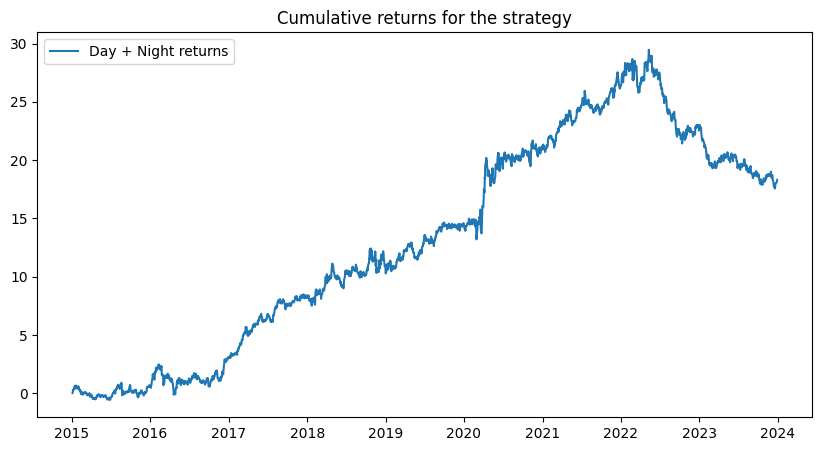

In [82]:
plt.figure(figsize=(10, 5))
plt.plot(Returns_df['Cumulative_returns'], label='Day + Night returns')
plt.title(f'Cumulative returns for the strategy')
plt.legend()
plt.show()
plt.close()


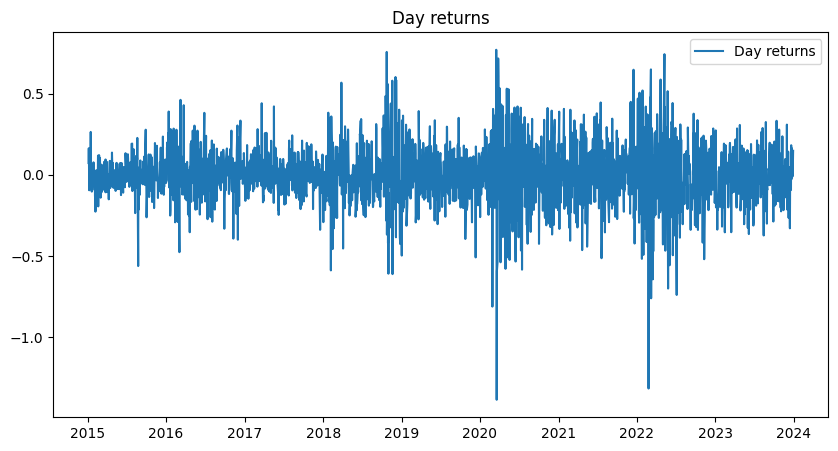

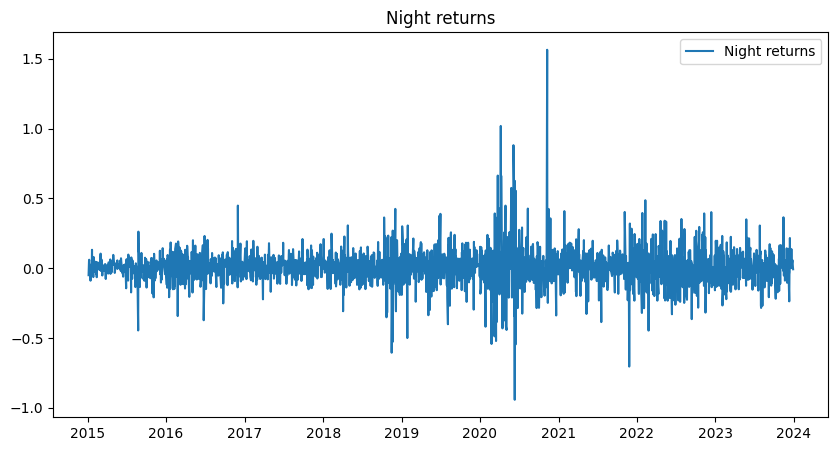

In [83]:
#plot the returns
plt.figure(figsize=(10, 5))
plt.plot(Returns_df['Day_returns'], label='Day returns')
plt.title(f'Day returns')
plt.legend()
plt.show()
plt.close()

#plot the returns
plt.figure(figsize=(10, 5))
plt.plot(Returns_df['Night_returns'], label='Night returns')
plt.title(f'Night returns')
plt.legend()
plt.show()
plt.close()


### Trading Strategy Overview 2
Long low-beta stocks by shorting high-beta stocks when markets opens (Day returns)

Long high-beta stocks by shorting low-beta stocks when markets closes (Night returns)


The trading amount is based on the methodologies from Frazinni and Pedersen (2014), as well as the Panel C in the paper

The Beta here is estimated by night returns


In [84]:

def get_extreme_beta_stocks(beta_df , i):
    row = beta_df.iloc[i]
    #select stocks only if they have positive betas top 10 and bottom 10
    top_10 = row[row>0].sort_values(ascending=False).head(10)
    bottom_10 = row[row>0].sort_values(ascending=True).head(10)

    top_10_stocks = top_10.index.tolist()
    bottom_10_stocks = bottom_10.index.tolist()

    return top_10_stocks, bottom_10_stocks

def get_daily_return(beta_df):
    Day_returns_holder = []
    Night_returns_holder = []
    monthflag = 0
    for i in range(len(beta_df)):
        #Checking if this is the new month, if yes, extract the top 10 and bottom 10 stocks again
        if beta_df.index[i].month != monthflag:
            daily_top10, daily_bottom10 = get_extreme_beta_stocks(beta_df , i)
            monthflag = beta_df.index[i].month

            daily_high_average_beta = beta_df.loc[beta_df.index[i], daily_top10].mean()
            daily_low_average_beta = beta_df.loc[beta_df.index[i], daily_bottom10].mean()

            high_beta_amount = (beta_df.loc[beta_df.index[i], daily_top10] )/daily_high_average_beta
            low_beta_amount = -(beta_df.loc[beta_df.index[i], daily_bottom10] )/daily_low_average_beta


        #Day returns
        high_beta_day_returns = (Day_returns_df.loc[Day_returns_df.index[i], daily_top10]* -high_beta_amount).sum()
        low_beta_day_returns = (Day_returns_df.loc[Day_returns_df.index[i], daily_bottom10]* -low_beta_amount).sum()
        Day_returns_holder.append(high_beta_day_returns + low_beta_day_returns)    

        #Night returns
        high_beta_night_returns = (Night_returns_df.loc[Night_returns_df.index[i], daily_top10] * high_beta_amount).sum()
        low_beta_night_returns = (Night_returns_df.loc[Night_returns_df.index[i], daily_bottom10] * low_beta_amount).sum()
        Night_returns_holder.append(high_beta_night_returns + low_beta_night_returns)

    return Day_returns_holder, Night_returns_holder


Day_returns_holder, Night_returns_holder = get_daily_return(beta_df)

        


In [85]:
Returns_df = pd.DataFrame(Day_returns_holder)
Returns_df.index = beta_df.index
Returns_df.columns = ['Day_returns']
Returns_df['Night_returns'] = Night_returns_holder
Returns_df['Total_returns'] = Returns_df['Day_returns'] + Returns_df['Night_returns']

#The returns are not based on the initial investment amount
Returns_df['Cumulative_returns'] = Returns_df['Total_returns'].cumsum() 

#Sharpe
Day_Sharpe = (Returns_df['Day_returns'].mean()*(252**0.5)) / Returns_df['Day_returns'].std()
Night_Sharpe = (Returns_df['Night_returns'].mean()*(252**0.5)) / Returns_df['Night_returns'].std()
Total_Sharpe = (Returns_df['Total_returns'].mean()*(252**0.5)) / Returns_df['Total_returns'].std()
print(f"Day Sharpe: {Day_Sharpe}")
print(f"Night Sharpe: {Night_Sharpe}")
print(f"Total Sharpe: {Total_Sharpe}")

Day Sharpe: -0.031766104163573984
Night Sharpe: 0.9894125471974252
Total Sharpe: 0.5549788112252302


From the result above, it is better to invest only during the night time

# Final Thought
- The Day returns show a negative returns, unlike what the paper observe from 1992 - 2016.

However:
- The "Zero cost" trading is under the condition that no trading fees are incurred while it is not true in reality
- The strategy is too risky and unreliable
- Better invest with other strategies

